In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import tqdm
import timeit
import PIL.Image
import pickle
import seaborn as sns
import gc
import cv2
import keras
from keras import regularizers


from keras.models import Model, Input
from keras.layers import Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import RandomNormal
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.initializers import RandomNormal

import mlflow.keras

mlflow.keras.autolog()


%matplotlib inline

Using TensorFlow backend.


In [3]:
IM_HEIGHT = 137
IM_WIDTH = 236

In [4]:
def collect_gc():
    gc.collect()

def display_images(train_parqutet,train_csv, num_images=10):
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(12,12))
    for imageid in range(num_images):
        #print(imageid)
        image_rec = train_parqutet.iloc[imageid]
        image_id = image_rec["image_id"]
        #print (image_id)
        image_i = image_rec.drop("image_id") 
        img_arr = np.array(image_i).reshape(137,236).astype("float32")
        train_csv_rec = train_csv.loc[train_csv["image_id"] == image_id]
        img = PIL.Image.fromarray(img_arr)
        #print(imageid//5, imageid%5)
        ax[imageid//5, imageid%5].imshow(img)
        ax[imageid//5, imageid%5].set_title(str(np.array(train_csv_rec["image_id"])[0]))
        ax[imageid//5, imageid%5].axis("off")
        



In [5]:
def ser_df_frame(df, fname):
    with open(fname, "wb") as output_file:
        pickle.dump(df, output_file,protocol=4)
        
def load_pickle_data(fname):
    with open(fname, "rb") as input_file:
        df = pickle.load(input_file)
    return df

In [6]:
X_train_updated = load_pickle_data("X_train_resizwed.pkl")
#X_train = np.array(X_train_updated)
#del X_train_updated
#gc.collect()

In [7]:
y_grapheme_root = load_pickle_data("y_grapheme.pkl").values
y_vowel_diatric = load_pickle_data("y_vowel_diatric.pkl").values
y_consonant_diatric = load_pickle_data("y_consonant_diatric.pkl").values

In [8]:
type(y_grapheme_root)

numpy.ndarray

In [9]:
y_grapheme_root_dum = pd.get_dummies(y_grapheme_root).values
y_vowel_diatric_dum = pd.get_dummies(y_vowel_diatric).values
y_consonant_diatric_dum = pd.get_dummies(y_consonant_diatric).values

In [10]:
x_train, x_test, y_train_root,y_test_root,y_train_vowel, y_test_vowel,y_train_consonant, y_test_consonant = train_test_split(X_train_updated, y_grapheme_root_dum,y_vowel_diatric_dum,y_consonant_diatric_dum, test_size=0.1, random_state=42)  

In [11]:
x_train=np.array(x_train)
x_test=np.array(x_test)

In [12]:
x_train = x_train.reshape(x_train.shape[0], 128,128,1)

In [13]:
x_test = x_test.reshape(x_test.shape[0],128,128,1)

In [14]:
#x_train /= x_train/255.

In [15]:
#x_test /= x_test/255.

# Model Build
Trying a very simple CNN model

In [27]:
from keras.utils import multi_gpu_model

IMG_SIZE = 128
inputs = Input(shape = (IMG_SIZE, IMG_SIZE,1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', 
               input_shape=(IMG_SIZE, IMG_SIZE,1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax', name="root")(dense)
head_vowel = Dense(11, activation = 'softmax', name="vowel")(dense)
head_consonant = Dense(7, activation = 'softmax', name="consonants")(dense)

#https://keras.io/regularizers/
#model.add(Dense(64, input_dim=64,
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01)))

tf.distribute.MirroredStrategy()
model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

#optzer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#optzer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#parallel_model = multi_gpu_model(model, gpus=2)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

In [21]:
history = model.fit(x_train, {'root':y_train_root, 'vowel':y_train_vowel,'consonants':y_train_consonant}, epochs=50, verbose=1, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]))


Train on 180756 samples, validate on 20084 samples
Epoch 1/50
180756/180756 [==============================] - 456s 3ms/step - loss: 2.7216 - root_loss: 1.9953 - vowel_loss: 0.3977 - consonants_loss: 0.3285 - root_acc: 0.4495 - vowel_acc: 0.8685 - consonants_acc: 0.8909 - val_loss: 1.1362 - val_root_loss: 0.7788 - val_vowel_loss: 0.1931 - val_consonants_loss: 0.1643 - val_root_acc: 0.7675 - val_vowel_acc: 0.9386 - val_consonants_acc: 0.9487
Epoch 2/50
180756/180756 [==============================] - 458s 3ms/step - loss: 1.1441 - root_loss: 0.7653 - vowel_loss: 0.2051 - consonants_loss: 0.1737 - root_acc: 0.7761 - vowel_acc: 0.9362 - consonants_acc: 0.9454 - val_loss: 0.7938 - val_root_loss: 0.5173 - val_vowel_loss: 0.1467 - val_consonants_loss: 0.1298 - val_root_acc: 0.8469 - val_vowel_acc: 0.9551 - val_consonants_acc: 0.9597
Epoch 3/50
180756/180756 [==============================] - 459s 3ms/step - loss: 0.8388 - root_loss: 0.5501 - vowel_loss: 0.1542 - consonants_loss: 0.1345 - roo

Epoch 22/50
180756/180756 [==============================] - 458s 3ms/step - loss: 0.3692 - root_loss: 0.2429 - vowel_loss: 0.0681 - consonants_loss: 0.0583 - root_acc: 0.9367 - vowel_acc: 0.9826 - consonants_acc: 0.9845 - val_loss: 0.5556 - val_root_loss: 0.3557 - val_vowel_loss: 0.1073 - val_consonants_loss: 0.0926 - val_root_acc: 0.9233 - val_vowel_acc: 0.9797 - val_consonants_acc: 0.9790
Epoch 23/50
180756/180756 [==============================] - 458s 3ms/step - loss: 0.3661 - root_loss: 0.2415 - vowel_loss: 0.0682 - consonants_loss: 0.0564 - root_acc: 0.9371 - vowel_acc: 0.9829 - consonants_acc: 0.9848 - val_loss: 0.5828 - val_root_loss: 0.3809 - val_vowel_loss: 0.1062 - val_consonants_loss: 0.0956 - val_root_acc: 0.9172 - val_vowel_acc: 0.9774 - val_consonants_acc: 0.9780
Epoch 24/50
180756/180756 [==============================] - 456s 3ms/step - loss: 0.3648 - root_loss: 0.2405 - vowel_loss: 0.0671 - consonants_loss: 0.0572 - root_acc: 0.9385 - vowel_acc: 0.9833 - consonants_a

Epoch 43/50
180756/180756 [==============================] - 459s 3ms/step - loss: 0.3591 - root_loss: 0.2390 - vowel_loss: 0.0657 - consonants_loss: 0.0543 - root_acc: 0.9484 - vowel_acc: 0.9859 - consonants_acc: 0.9875 - val_loss: 0.7358 - val_root_loss: 0.4797 - val_vowel_loss: 0.1322 - val_consonants_loss: 0.1240 - val_root_acc: 0.9235 - val_vowel_acc: 0.9804 - val_consonants_acc: 0.9788
Epoch 44/50
180756/180756 [==============================] - 458s 3ms/step - loss: 0.3696 - root_loss: 0.2485 - vowel_loss: 0.0683 - consonants_loss: 0.0529 - root_acc: 0.9483 - vowel_acc: 0.9854 - consonants_acc: 0.9879 - val_loss: 0.7904 - val_root_loss: 0.5141 - val_vowel_loss: 0.1461 - val_consonants_loss: 0.1302 - val_root_acc: 0.9228 - val_vowel_acc: 0.9780 - val_consonants_acc: 0.9785
Epoch 45/50
180756/180756 [==============================] - 458s 3ms/step - loss: 0.3585 - root_loss: 0.2405 - vowel_loss: 0.0643 - consonants_loss: 0.0537 - root_acc: 0.9486 - vowel_acc: 0.9864 - consonants_a

In [22]:

model.save('Bengali_model_v2.h5')

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [23]:
def get_train_test_files():
    train_files =[]
    test_files = []
    for name in os.listdir():
        if name.split(".")[-1] == "parquet":
            if name.split("_")[0] == "train":
                train_files.append(name)
            else:
                test_files.append(name)
    train_files.sort()
    test_files.sort()
    return train_files, test_files

In [24]:
def test_train_files():
    train_files, test_files = get_train_test_files()
    print(train_files)
    print(test_files)

In [25]:
def load_test_data():
    train_files, test_files = get_train_test_files()
    mast_test = pd.DataFrame()
    for parfile in test_files:
        print(parfile)
        test_parqutet = pd.read_parquet(parfile)
        mast_test = mast_test.append(test_parqutet)
    #print (mast_train.)
    return mast_test

In [50]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['root_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['vowel_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['consonants_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_root_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_vowel_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_consonants_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['root_acc'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['vowel_acc'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['consonants_acc'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_root_acc'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_vowel_acc'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_consonants_acc'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

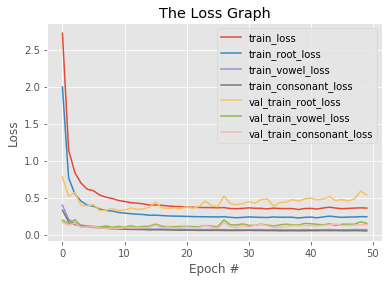

In [51]:
plot_loss(history, 50, "The Loss Graph")

In [52]:
history.history.keys()
    

dict_keys(['val_loss', 'val_root_loss', 'val_vowel_loss', 'val_consonants_loss', 'val_root_acc', 'val_vowel_acc', 'val_consonants_acc', 'loss', 'root_loss', 'vowel_loss', 'consonants_loss', 'root_acc', 'vowel_acc', 'consonants_acc'])

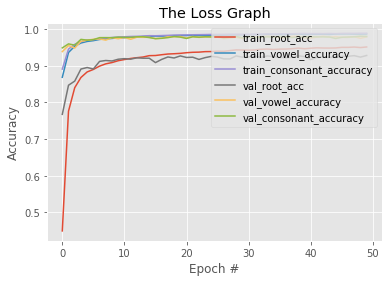

In [53]:
plot_acc(history, 50, "The Accuracy Graph")

In [54]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [2]:
def resize_images(X_train):
    resized_img = {}
    for i in range(len(X_train)):
        img =  X_train[i]
        #print (img.shape)
        img = resize(img.astype("float32"), (128,128))
        resized_img[i] = img
    return resized_img

In [28]:
from keras.models import load_model
model = load_model("models/Bengali_model_v2.h5")

/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:
W0117 21:00:07.424379 139753397233408 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm
IMG_SIZE=128
N_CHANNELS=1

def reshape_array(df):
    X_train = np.array(df,dtype="float32")
    X_train = X_train.reshape(len(df), IM_HEIGHT,IM_WIDTH)
    return X_train

def resize_images(X_train):
    resized_img = np.empty([128,128])
    #print (resized_img.shape)
    for i in range(len(X_train)):
        #print (i)
        img =  X_train[i]
        #print (img.shape)
        img = resize(img.astype("float32"), (128,128))
        #print (img.shape)
        #resized_img[i] = img
        resized_img = np.vstack((resized_img,img))
    return resized_img

In [30]:
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm
IMG_SIZE=128
N_CHANNELS=1

preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}


components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('test_image_data_{}.parquet'.format(i)) 
    image_ids = df_test_img["image_id"]
    df_test_img.drop(columns=["image_id"],inplace=True)
    X_test = reshape_array(df_test_img)
    
    
    X_test = resize_images(X_test)
    X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(image_ids.index.values):  
        for i,comp in enumerate(components):
            id_sample=str(id)+'_'+ str(comp)
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,0_consonant_diacritic,4
1,0_grapheme_root,9
2,0_vowel_diacritic,1
3,1_consonant_diacritic,0
4,1_grapheme_root,3


In [31]:
!cat submission.csv

row_id,target
0_consonant_diacritic,4
0_grapheme_root,9
0_vowel_diacritic,1
1_consonant_diacritic,0
1_grapheme_root,3
1_vowel_diacritic,0
2_consonant_diacritic,0
2_grapheme_root,93
2_vowel_diacritic,2
0_consonant_diacritic,4
0_grapheme_root,9
0_vowel_diacritic,1
1_consonant_diacritic,0
1_grapheme_root,115
1_vowel_diacritic,0
2_consonant_diacritic,0
2_grapheme_root,55
2_vowel_diacritic,4
0_consonant_diacritic,4
0_grapheme_root,96
0_vowel_diacritic,1
1_consonant_diacritic,5
1_grapheme_root,147
1_vowel_diacritic,9
2_consonant_diacritic,0
2_grapheme_root,137
2_vowel_diacritic,7
0_consonant_diacritic,1
0_grapheme_root,87
0_vowel_diacritic,4
1_consonant_diacritic,0
1_grapheme_root,133
1_vowel_diacritic,10
2_consonant_diacritic,4
2_grapheme_root,148
2_vowel_diacritic,1


In [36]:
i=1
df_test_img = pd.read_parquet('test_image_data_{}.parquet'.format(3)) 
#df_test_img.set_index('image_id', inplace=True)
image_ids = df_test_img["image_id"]
df_test_img.drop(columns=["image_id"],inplace=True)
X_test = np.array(df_test_img)
X_test = reshape_array(X_test)
X_test = resize_images(X_test)

0
1
2


In [8]:
import numpy as np

arr = np.empty([0,3])
arr =np.vstack((arr,[1,2,3]))
arr = np.vstack((arr,[4,5,6]))

arr.shape


(2, 3)

In [34]:
len(X_test.values())

3

In [44]:
X_test  = X_test.values()

In [57]:
print(len(preds))

3


In [37]:
IMG_SIZE = 128
inputs = Input(shape = (IMG_SIZE, IMG_SIZE,1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation="elu", 
               input_shape=(IMG_SIZE, IMG_SIZE,1))(inputs)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
#model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='elu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='elu')(model)
#model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='elu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='elu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='elu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='elu')(model)
#model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='elu')(model)
#model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='elu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='elu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "elu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "elu")(model)

head_root = Dense(168, activation = 'softmax', name="root")(dense)
head_vowel = Dense(11, activation = 'softmax', name="vowel")(dense)
head_consonant = Dense(7, activation = 'softmax', name="consonants")(dense)

#https://keras.io/regularizers/
#model.add(Dense(64, input_dim=64,
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01)))


model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

#optzer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#parallel_model = multi_gpu_model(model, gpus=3)

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])